# Chapter 6: Physics Libraries（物理ライブラリ）

このノートブックは [Nature of Code](https://natureofcode.com/physics-libraries/) の第6章をJuliaで実装したものです。

## 概要

これまでの章では、物理シミュレーションを一から実装してきました。
しかし、より複雑なシミュレーション（剛体力学、衝突検出、拘束など）には
専用の物理ライブラリを使用することが効率的です。

オリジナルの本では**Matter.js**（剛体物理）と**Toxiclibs.js**（Verlet物理）が紹介されています。
Juliaでは、これらの概念を理解しつつ、独自の実装を行います。

In [1]:
using LinearAlgebra
using Plots

# ヘルパー関数
normalize(v) = norm(v) > 0 ? v / norm(v) : v
setmag(v, m) = normalize(v) * m
limit(v, max) = norm(v) > max ? setmag(v, max) : v

limit (generic function with 1 method)

## 6.1 物理エンジンの構造

物理エンジンは通常、以下のコンポーネントで構成されます：

1. **World（ワールド）**: すべてのオブジェクトを管理
2. **Body（ボディ）**: 剛体（矩形、円など）
3. **Constraint（拘束）**: オブジェクト間の接続
4. **Collision Detection（衝突検出）**: 衝突の検出と応答

In [2]:
# シンプルな物理ワールド
mutable struct PhysicsWorld
    gravity::Vector{Float64}
    bodies::Vector{Any}
    constraints::Vector{Any}
end

PhysicsWorld() = PhysicsWorld([0.0, 0.1], [], [])

function addBody!(world::PhysicsWorld, body)
    push!(world.bodies, body)
end

function addConstraint!(world::PhysicsWorld, constraint)
    push!(world.constraints, constraint)
end

addConstraint! (generic function with 1 method)

## 6.2 Rigid Body（剛体）

剛体は変形しない物体です。位置、速度、角度、角速度を持ちます。

In [3]:
mutable struct RigidBody
    position::Vector{Float64}
    velocity::Vector{Float64}
    acceleration::Vector{Float64}
    angle::Float64
    angularVelocity::Float64
    mass::Float64
    friction::Float64
    restitution::Float64  # 反発係数
    isStatic::Bool
    width::Float64
    height::Float64
end

function RigidBody(x::Float64, y::Float64, w::Float64, h::Float64; isStatic=false)
    RigidBody(
        [x, y],           # position
        [0.0, 0.0],       # velocity
        [0.0, 0.0],       # acceleration
        0.0,              # angle
        0.0,              # angularVelocity
        w * h * 0.001,    # mass (密度に基づく)
        0.1,              # friction
        0.8,              # restitution
        isStatic,
        w, h
    )
end

function applyForce!(body::RigidBody, force::Vector{Float64})
    if !body.isStatic
        body.acceleration .+= force ./ body.mass
    end
end

function update!(body::RigidBody, gravity::Vector{Float64})
    if body.isStatic
        return
    end
    
    # 重力を適用
    body.acceleration .+= gravity
    
    # 速度と位置を更新
    body.velocity .+= body.acceleration
    body.velocity .*= (1 - body.friction * 0.01)  # 摩擦
    body.position .+= body.velocity
    body.acceleration .= 0.0
    
    # 回転
    body.angle += body.angularVelocity
    body.angularVelocity *= 0.99
end

update! (generic function with 1 method)

## 6.3 Circle Body（円形ボディ）

In [4]:
mutable struct CircleBody
    position::Vector{Float64}
    velocity::Vector{Float64}
    acceleration::Vector{Float64}
    radius::Float64
    mass::Float64
    restitution::Float64
    isStatic::Bool
end

function CircleBody(x::Float64, y::Float64, r::Float64; isStatic=false)
    CircleBody(
        [x, y],
        [0.0, 0.0],
        [0.0, 0.0],
        r,
        π * r^2 * 0.001,
        0.8,
        isStatic
    )
end

function update!(body::CircleBody, gravity::Vector{Float64})
    if body.isStatic
        return
    end
    
    body.acceleration .+= gravity
    body.velocity .+= body.acceleration
    body.position .+= body.velocity
    body.acceleration .= 0.0
end

update! (generic function with 2 methods)

## 6.4 衝突検出と応答

物理エンジンの核心部分です。ここでは円同士の衝突を実装します。

In [5]:
# 円同士の衝突検出
function checkCollision(a::CircleBody, b::CircleBody)
    d = norm(a.position - b.position)
    return d < a.radius + b.radius
end

# 衝突応答（弾性衝突）
function resolveCollision!(a::CircleBody, b::CircleBody)
    if !checkCollision(a, b)
        return
    end
    
    # 衝突法線
    normal = normalize(b.position - a.position)
    
    # 相対速度
    relativeVelocity = a.velocity - b.velocity
    velAlongNormal = dot(relativeVelocity, normal)
    
    # 離れていく方向なら何もしない
    if velAlongNormal > 0
        return
    end
    
    # 反発係数
    e = min(a.restitution, b.restitution)
    
    # 撃力の大きさ
    if a.isStatic
        j = -(1 + e) * velAlongNormal
        b.velocity .-= j * normal
    elseif b.isStatic
        j = -(1 + e) * velAlongNormal
        a.velocity .+= j * normal
    else
        j = -(1 + e) * velAlongNormal / (1/a.mass + 1/b.mass)
        impulse = j * normal
        a.velocity .+= impulse / a.mass
        b.velocity .-= impulse / b.mass
    end
    
    # 重なりの解消
    d = norm(b.position - a.position)
    overlap = (a.radius + b.radius - d) / 2
    
    if !a.isStatic && !b.isStatic
        a.position .-= overlap * normal
        b.position .+= overlap * normal
    elseif a.isStatic
        b.position .+= 2 * overlap * normal
    else
        a.position .-= 2 * overlap * normal
    end
end

resolveCollision! (generic function with 1 method)

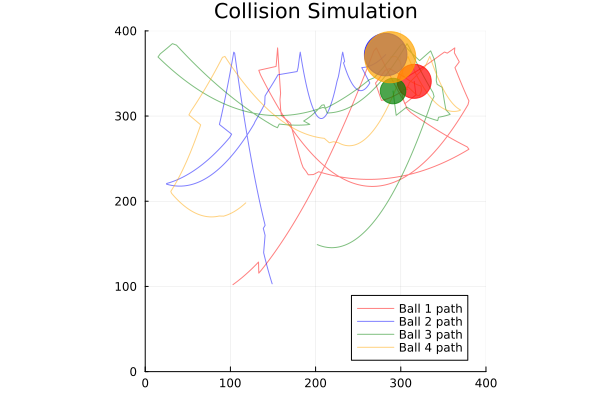

In [6]:
# 衝突シミュレーション
function simulate_collision()
    # ボールを作成
    balls = [
        CircleBody(100.0, 100.0, 20.0),
        CircleBody(150.0, 100.0, 25.0),
        CircleBody(200.0, 150.0, 15.0),
        CircleBody(120.0, 200.0, 30.0),
    ]
    
    # 初期速度
    balls[1].velocity = [3.0, 2.0]
    balls[2].velocity = [-1.0, 3.0]
    balls[3].velocity = [2.0, -1.0]
    balls[4].velocity = [-2.0, -2.0]
    
    gravity = [0.0, 0.1]
    width, height = 400.0, 400.0
    
    # 軌跡を記録
    history = [Vector{Vector{Float64}}() for _ in 1:length(balls)]
    
    for _ in 1:300
        # 更新
        for ball in balls
            update!(ball, gravity)
        end
        
        # ボール同士の衝突
        for i in 1:length(balls)
            for j in i+1:length(balls)
                resolveCollision!(balls[i], balls[j])
            end
        end
        
        # 壁との衝突
        for ball in balls
            if ball.position[1] - ball.radius < 0
                ball.position[1] = ball.radius
                ball.velocity[1] *= -ball.restitution
            end
            if ball.position[1] + ball.radius > width
                ball.position[1] = width - ball.radius
                ball.velocity[1] *= -ball.restitution
            end
            if ball.position[2] - ball.radius < 0
                ball.position[2] = ball.radius
                ball.velocity[2] *= -ball.restitution
            end
            if ball.position[2] + ball.radius > height
                ball.position[2] = height - ball.radius
                ball.velocity[2] *= -ball.restitution
            end
        end
        
        for (i, ball) in enumerate(balls)
            push!(history[i], copy(ball.position))
        end
    end
    
    # プロット
    colors = [:red, :blue, :green, :orange]
    p = plot(xlims=(0, width), ylims=(0, height), aspect_ratio=:equal)
    
    for (i, h) in enumerate(history)
        xs = [pos[1] for pos in h]
        ys = [pos[2] for pos in h]
        plot!(xs, ys, color=colors[i], alpha=0.5, label="Ball $i path")
    end
    
    # 最終位置
    for (i, ball) in enumerate(balls)
        θ = range(0, 2π, length=50)
        cx = ball.position[1] .+ ball.radius .* cos.(θ)
        cy = ball.position[2] .+ ball.radius .* sin.(θ)
        plot!(cx, cy, fill=true, color=colors[i], alpha=0.7, label="")
    end
    
    title!("Collision Simulation")
end

simulate_collision()

## 6.5 Constraints（拘束）

拘束は2つのボディ間の関係を定義します。
最も基本的なのは**距離拘束（バネ）**です。

In [7]:
struct DistanceConstraint
    bodyA::CircleBody
    bodyB::CircleBody
    length::Float64
    stiffness::Float64  # 0-1, 1が最も硬い
end

function solve!(c::DistanceConstraint)
    delta = c.bodyB.position - c.bodyA.position
    d = norm(delta)
    
    if d == 0
        return
    end
    
    diff = (d - c.length) / d
    
    if !c.bodyA.isStatic && !c.bodyB.isStatic
        c.bodyA.position .+= delta * 0.5 * diff * c.stiffness
        c.bodyB.position .-= delta * 0.5 * diff * c.stiffness
    elseif c.bodyA.isStatic
        c.bodyB.position .-= delta * diff * c.stiffness
    else
        c.bodyA.position .+= delta * diff * c.stiffness
    end
end

solve! (generic function with 1 method)

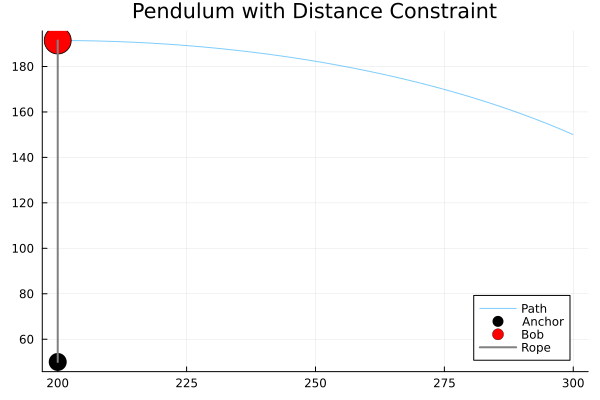

In [8]:
# 振り子のシミュレーション（拘束を使用）
function simulate_pendulum()
    # 固定点
    anchor = CircleBody(200.0, 50.0, 5.0, isStatic=true)
    
    # 振り子のボブ
    bob = CircleBody(300.0, 150.0, 15.0)
    
    # 距離拘束
    ropeLength = norm(bob.position - anchor.position)
    constraint = DistanceConstraint(anchor, bob, ropeLength, 1.0)
    
    gravity = [0.0, 0.2]
    history = Vector{Vector{Float64}}()
    
    for _ in 1:500
        # 重力を適用
        bob.velocity .+= gravity
        bob.velocity .*= 0.999  # 減衰
        bob.position .+= bob.velocity
        
        # 拘束を解決（複数回反復で安定性向上）
        for _ in 1:10
            solve!(constraint)
        end
        
        push!(history, copy(bob.position))
    end
    
    # プロット
    xs = [p[1] for p in history]
    ys = [p[2] for p in history]
    
    plot(xs, ys, alpha=0.5, label="Path")
    scatter!([anchor.position[1]], [anchor.position[2]], 
             markersize=10, color=:black, label="Anchor")
    scatter!([bob.position[1]], [bob.position[2]], 
             markersize=15, color=:red, label="Bob")
    plot!([anchor.position[1], bob.position[1]], 
          [anchor.position[2], bob.position[2]], 
          linewidth=2, color=:gray, label="Rope")
    title!("Pendulum with Distance Constraint")
end

simulate_pendulum()

## 6.6 Verlet Integration（Verlet積分）

Toxiclibs.jsで使用されているVerlet積分は、バネ接続されたパーティクルシステムに最適です。
速度を明示的に保持せず、前フレームの位置から暗黙的に計算します。

```
velocity = position - previousPosition
nextPosition = position + velocity + acceleration
```

In [9]:
mutable struct VerletParticle
    position::Vector{Float64}
    previousPosition::Vector{Float64}
    acceleration::Vector{Float64}
    isLocked::Bool
end

function VerletParticle(x::Float64, y::Float64; locked=false)
    VerletParticle([x, y], [x, y], [0.0, 0.0], locked)
end

function update!(p::VerletParticle, gravity::Vector{Float64})
    if p.isLocked
        return
    end
    
    # 速度は位置の差分から暗黙的に計算される
    velocity = p.position - p.previousPosition
    
    # 次の位置
    nextPos = p.position + velocity + gravity
    
    p.previousPosition = copy(p.position)
    p.position = nextPos
    p.acceleration .= 0.0
end

update! (generic function with 3 methods)

In [10]:
struct VerletSpring
    a::VerletParticle
    b::VerletParticle
    restLength::Float64
    stiffness::Float64
end

function solve!(s::VerletSpring)
    delta = s.b.position - s.a.position
    d = norm(delta)
    
    if d == 0
        return
    end
    
    diff = (s.restLength - d) / d * s.stiffness
    offset = delta * diff * 0.5
    
    if !s.a.isLocked
        s.a.position .-= offset
    end
    if !s.b.isLocked
        s.b.position .+= offset
    end
end

solve! (generic function with 2 methods)

## 6.7 Soft Body（ソフトボディ）

Verlet粒子とバネを組み合わせて、柔らかい物体を作成します。

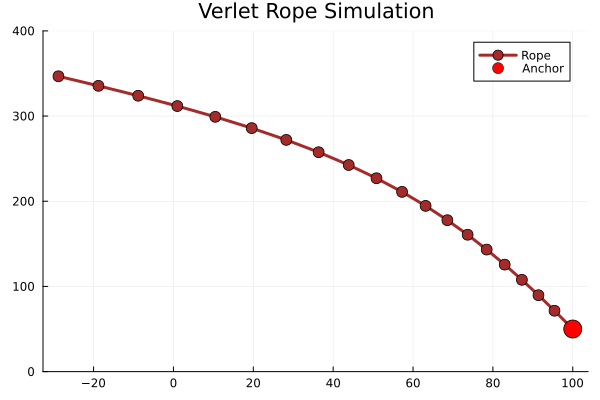

In [11]:
# ロープ（Chain）のシミュレーション
function simulate_rope()
    numPoints = 20
    restLength = 15.0
    
    # パーティクルを作成
    particles = [VerletParticle(100.0 + i * restLength, 50.0) for i in 0:numPoints-1]
    particles[1].isLocked = true  # 最初の点を固定
    
    # バネで接続
    springs = [VerletSpring(particles[i], particles[i+1], restLength, 0.9) 
               for i in 1:numPoints-1]
    
    gravity = [0.0, 0.5]
    history = [Vector{Vector{Float64}}() for _ in 1:numPoints]
    
    for _ in 1:200
        # パーティクルを更新
        for p in particles
            update!(p, gravity)
        end
        
        # バネを解決（複数回反復）
        for _ in 1:5
            for s in springs
                solve!(s)
            end
        end
        
        for (i, p) in enumerate(particles)
            push!(history[i], copy(p.position))
        end
    end
    
    # 最終状態をプロット
    xs = [p.position[1] for p in particles]
    ys = [p.position[2] for p in particles]
    
    plot(xs, ys, linewidth=3, marker=:circle, markersize=6, 
         color=:brown, label="Rope")
    scatter!([particles[1].position[1]], [particles[1].position[2]], 
             markersize=10, color=:red, label="Anchor")
    title!("Verlet Rope Simulation")
    ylims!(0, 400)
end

simulate_rope()

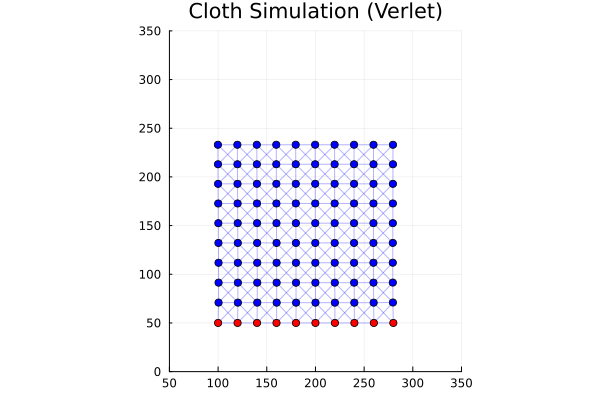

In [12]:
# ソフトボディ（布）のシミュレーション
function simulate_cloth()
    cols, rows = 10, 10
    spacing = 20.0
    stiffness = 0.8
    
    # グリッド状にパーティクルを配置
    particles = Matrix{VerletParticle}(undef, cols, rows)
    for i in 1:cols
        for j in 1:rows
            x = 100.0 + (i-1) * spacing
            y = 50.0 + (j-1) * spacing
            particles[i, j] = VerletParticle(x, y)
        end
    end
    
    # 上端を固定
    for i in 1:cols
        particles[i, 1].isLocked = true
    end
    
    # バネを作成（水平と垂直）
    springs = VerletSpring[]
    
    for i in 1:cols
        for j in 1:rows
            # 右隣
            if i < cols
                push!(springs, VerletSpring(particles[i,j], particles[i+1,j], spacing, stiffness))
            end
            # 下隣
            if j < rows
                push!(springs, VerletSpring(particles[i,j], particles[i,j+1], spacing, stiffness))
            end
            # 対角（構造的安定性のため）
            if i < cols && j < rows
                push!(springs, VerletSpring(particles[i,j], particles[i+1,j+1], spacing*√2, stiffness*0.5))
            end
            if i > 1 && j < rows
                push!(springs, VerletSpring(particles[i,j], particles[i-1,j+1], spacing*√2, stiffness*0.5))
            end
        end
    end
    
    gravity = [0.0, 0.3]
    
    for _ in 1:300
        for i in 1:cols
            for j in 1:rows
                update!(particles[i,j], gravity)
            end
        end
        
        for _ in 1:5
            for s in springs
                solve!(s)
            end
        end
    end
    
    # プロット
    p = plot(xlims=(50, 350), ylims=(0, 350), aspect_ratio=:equal)
    
    # バネを描画
    for s in springs
        plot!([s.a.position[1], s.b.position[1]], 
              [s.a.position[2], s.b.position[2]], 
              color=:blue, alpha=0.3, label="")
    end
    
    # パーティクルを描画
    for i in 1:cols
        for j in 1:rows
            c = particles[i,j].isLocked ? :red : :blue
            scatter!([particles[i,j].position[1]], [particles[i,j].position[2]], 
                     markersize=4, color=c, label="")
        end
    end
    
    title!("Cloth Simulation (Verlet)")
end

simulate_cloth()

## 6.8 Attraction Behavior（引力行動）

Toxiclibs.jsのAttractionBehaviorに相当するものを実装します。

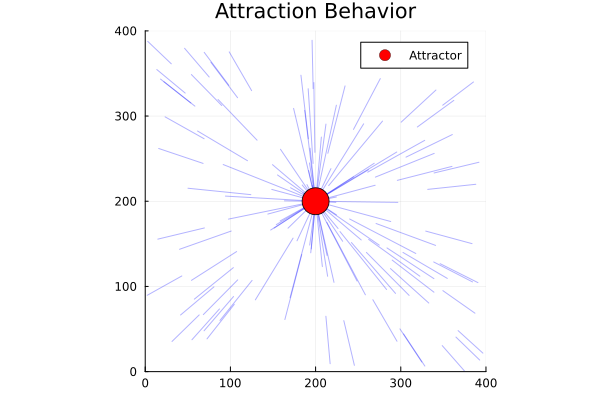

In [13]:
struct Attractor
    position::Vector{Float64}
    radius::Float64
    strength::Float64  # 正で引力、負で斥力
end

function applyAttraction!(p::VerletParticle, attractor::Attractor)
    if p.isLocked
        return
    end
    
    delta = attractor.position - p.position
    d = norm(delta)
    
    if d < attractor.radius && d > 1
        # 距離に反比例する力
        force = normalize(delta) * attractor.strength / d
        p.position .+= force
    end
end

function simulate_attraction()
    # ランダムなパーティクル
    particles = [VerletParticle(rand()*400, rand()*400) for _ in 1:100]
    
    # 引力点
    attractor = Attractor([200.0, 200.0], 300.0, 0.5)
    
    history = [Vector{Vector{Float64}}() for _ in 1:length(particles)]
    
    for _ in 1:200
        for (i, p) in enumerate(particles)
            applyAttraction!(p, attractor)
            update!(p, [0.0, 0.0])  # 重力なし
            push!(history[i], copy(p.position))
        end
    end
    
    # プロット
    p = plot(xlims=(0, 400), ylims=(0, 400), aspect_ratio=:equal)
    
    for h in history
        xs = [pos[1] for pos in h]
        ys = [pos[2] for pos in h]
        plot!(xs, ys, alpha=0.3, color=:blue, label="")
    end
    
    scatter!([attractor.position[1]], [attractor.position[2]], 
             markersize=15, color=:red, label="Attractor")
    title!("Attraction Behavior")
end

simulate_attraction()

## 6.9 ライブラリ選択のガイドライン

| ユースケース | 推奨 |
|-------------|------|
| 剛体の衝突 | Matter.js相当（剛体物理） |
| バネ/ロープ/布 | Toxiclibs.js相当（Verlet物理） |
| ソフトボディ | Verlet物理 |
| 複雑な形状 | 剛体物理（Compound Bodies） |
| パーティクルシステム | Verlet物理 |

### Julia用の物理ライブラリ

- **RigidBodyDynamics.jl**: ロボティクス向けの剛体力学
- **DifferentialEquations.jl**: 汎用の微分方程式ソルバー
- **Bullet.jl**: Bullet Physics Engineへのバインディング

## まとめ

この章では、物理エンジンの基本概念を学びました：

1. **剛体（Rigid Body）**: 変形しない物体、位置・速度・角度を持つ
2. **衝突検出**: オブジェクト間の接触を検出
3. **衝突応答**: 弾性衝突による速度変化
4. **拘束（Constraint）**: 距離拘束、ヒンジなど
5. **Verlet積分**: バネシステムに最適な積分法
6. **ソフトボディ**: Verlet粒子とバネによる柔らかい物体

### 重要な概念

- 物理計算と描画を分離する
- 拘束は反復して解決することで安定する
- Euler法よりVerlet法がバネシステムに適している